In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

import keras
from keras import losses
from keras.datasets import mnist
from keras.models import Sequential

from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU
from keras import backend as K
from keras.optimizers import Adam

from keras.models import model_from_json

from dataset import *
import itertools

Using TensorFlow backend.


In [8]:
imgs, gt_imgs = training_dataset(limit=30)
print('Image size = ', imgs[0].shape)

Loading 30 training images
Loading 30 groundtruth images
Image size =  (400, 400, 3)


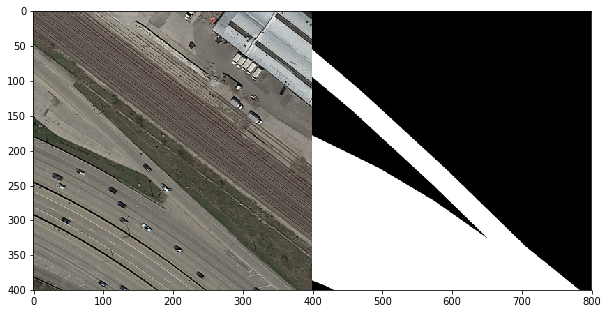

In [9]:
# Show 5th image and its groundtruth image
cimg = concatenate_images(imgs[5], gt_imgs[5])
fig1 = plt.figure(figsize=(10, 10))
plt.imshow(cimg, cmap='Greys_r')

In [10]:
patch_size = 16 # each patch is 16*16 pixels

In [11]:
def value_to_class(v, foreground_threshold = 0.25):
    df = np.mean(v)
    return (df > foreground_threshold) * 1

In [12]:
def image_to_patches(img, func):
    p = img.shape
    assert p[0] == p[1]
    n = p[0]
    patches = [
        func(img, i, j)
        for i in range(2*patch_size, n - 3*patch_size+1, patch_size)
        for j in range(2*patch_size, n - 3*patch_size+1, patch_size)
    ]
    return patches

def get_image_crop(img, i, j):
    return img[i-2*patch_size:i+3*patch_size, j-2*patch_size:j+3*patch_size, :]

def get_groundtruth_crop(gt_img, i, j):
    return gt_img[i:i+patch_size, j:j+patch_size]

In [13]:
import random
def gen_warped_patches(img, gt, seed=42):
    random.seed(seed)
    n = img.shape[0]
    angle = random.choice([45, 135, 215, 285])
    rot_img = rotate_image(img, [angle])[0]
    rot_gt = rotate_image(gt, [angle])[0]
                           
    while True:        
        x = random.randrange(n)
        y = random.randrange(n)
        if (np.sum(rot_img[x,y]) != 0 and
            np.sum(rot_img[x,y+80-1]) != 0 and
            np.sum(rot_img[x+80-1,y]) != 0 and
            np.sum(rot_img[x+80-1,y+80-1])):            
            yield (
                rot_img[x:x+80,y:y+80,:],
                rot_gt[x+2*patch_size:x+3*patch_size,
                       y+2*patch_size:y+3*patch_size]
            )

In [14]:
all_img_patches = [
    patch
    for i in range(len(imgs))
    for patch in image_to_patches(reflect_border(imgs[i], patch_size, 2), get_image_crop)
    for trans_patch in image_trans(patch)
]

all_gt_patches = [
    gt_patch
    for i in range(len(gt_imgs))
    for gt_patch in image_to_patches(reflect_border(gt_imgs[i], patch_size, 2), get_groundtruth_crop)
    for j in range(8)
]

assert len(all_gt_patches) == len(all_img_patches)

X = np.asarray(all_img_patches)
y = np.asarray([value_to_class(gt_patch) for gt_patch in all_gt_patches]).reshape((-1, 1))

print(X.shape)
print(y.shape)

(150000, 80, 80, 3)
(150000, 1)


In [15]:
def train_test_split(X, y, test_ratio=0.8, seed=42):
    n = len(X)
    np.random.seed(seed)
    idxs = np.random.permutation(n)
    limit = int(test_ratio * n)
    X_train, y_train = X[idxs[:limit]], y[idxs[:limit]]
    X_test, y_test = X[idxs[limit:]], y[idxs[limit:]]
    return X_train, X_test, y_train, y_test

In [16]:
# the data, shuffled and split between train and test sets
x_train, x_test, y_train, y_test  = train_test_split(X, y, 0.8)

In [21]:
# Model parameters
batch_size = 32
num_filters_1 = 16
num_filters_2 = 32
num_filters_3 = 64
num_filters_4 = 128
epochs = 5

In [22]:
assert K.image_data_format() == 'channels_last'
input_shape = (5*patch_size, 5*patch_size, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('input shape', input_shape)

x_train shape: (120000, 80, 80, 3)
120000 train samples
30000 test samples
input shape (80, 80, 3)


In [23]:
model = Sequential()
model.add(Conv2D(num_filters_1, kernel_size=(4, 4), # kernel 5,5 or 4,4
                 #activation='relu',
                 input_shape=input_shape))

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_2, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_3, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Conv2D(num_filters_4, kernel_size=(4,4),
                 #activation='relu'
                )) # kernel 4,4 

model.add(LeakyReLU(alpha=0.1))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())

#model.add(Dense(400, activation='sigmoid'))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3), # 'rmsprop'
              metrics=['accuracy'])

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 77, 77, 16)        784       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 77, 77, 16)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 38, 38, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 35, 35, 32)        8224      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 35, 35, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 32)        0         
__________

In [25]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(x_test, y_test))

Train on 120000 samples, validate on 30000 samples
Epoch 1/5
120000/120000 [==============================] - 364s - loss: 0.2797 - acc: 0.8709 - val_loss: 0.1316 - val_acc: 0.9531
Epoch 2/5
120000/120000 [==============================] - 360s - loss: 0.1103 - acc: 0.9561 - val_loss: 0.0572 - val_acc: 0.9803
Epoch 3/5
120000/120000 [==============================] - 371s - loss: 0.0714 - acc: 0.9731 - val_loss: 0.0194 - val_acc: 0.9947
Epoch 4/5
120000/120000 [==============================] - 371s - loss: 0.0592 - acc: 0.9783 - val_loss: 0.0129 - val_acc: 0.9964
Epoch 5/5
120000/120000 [==============================] - 366s - loss: 0.0513 - acc: 0.9807 - val_loss: 0.0123 - val_acc: 0.9958


In [26]:
test_acc = np.mean((np.round(model.predict(x_test)) >= 0.5) * 1 == y_test)
print('Test accuracy:', test_acc)

Test accuracy: 0.9958


In [28]:
# Convert array of labels to an image

def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[i:i+w, j:j+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img
    

In [29]:
def print_prediction(img, gt_img, model):
    img_patches = [
        img_patch
        for img_patch in image_to_patches(reflect_border(img, patch_size, 2), get_image_crop)
    ]

    gt_labeled_patches = [
        value_to_class(gt_patch)
        for gt_patch in image_to_patches(reflect_border(gt_img, patch_size, 2), get_groundtruth_crop)
    ]

    predicted_patches = model.predict(np.asarray(img_patches))
    
    w = img.shape[0]
    h = img.shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, predicted_patches)
    
    
    print("Ground truth")
    cimg = concatenate_images(img, gt_img)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Ground truth patches")
    gt_im_patches = label_to_img(w, h, patch_size, patch_size, gt_labeled_patches)

    cimg = concatenate_images(img, gt_im_patches)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Predicted patches")

    cimg = concatenate_images(img, predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')
    plt.show()
    
    print("Prediction overlay")

    new_img = make_img_overlay(img, predicted_im)

    plt.imshow(new_img)


Ground truth


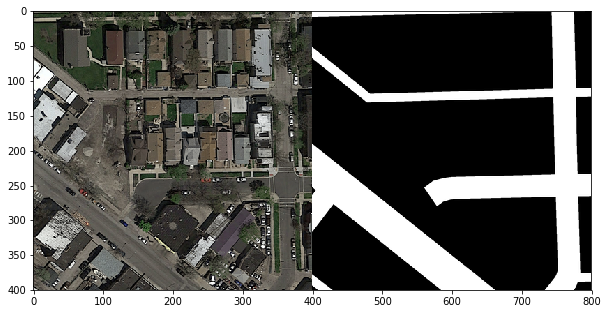

Ground truth patches


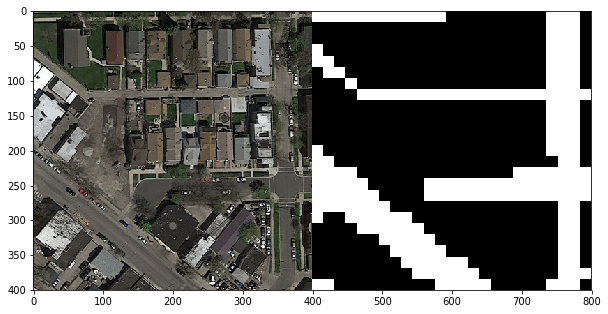

Predicted patches


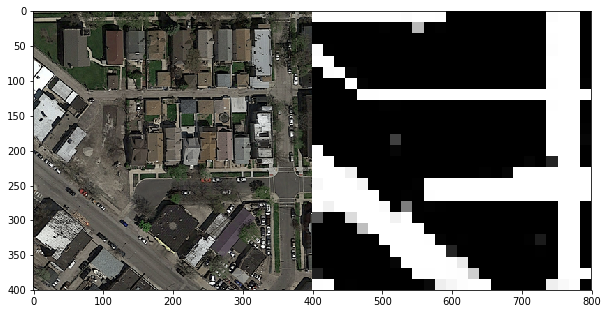

Prediction overlay


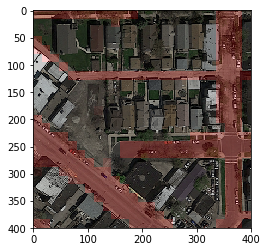

In [31]:
print_prediction(imgs[10], gt_imgs[10], model)

In [ ]:
plt.imshow(predicted_im)

In [27]:
# save the model and the weights to files
model_json = model.to_json()
f = open('savedModels/model_15', 'w')
f.write(model_json)
f.close()
model.save_weights('savedModels/weights_15')


In [ ]:
# load model to test
fm = open('alfonso_gpu.model')
model_2 = model_from_json(fm.read())
model_2.load_weights('alfonso_gpu.weights', by_name=False)
fm.close()

model_2.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-3),#'rmsprop',
              metrics=['accuracy'])

model_2.evaluate(x_test, y_test, verbose=1, batch_size=batch_size)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=45,
                             horizontal_flip=True,
                             vertical_flip=True,
                             channel_shift_range=0.02, fill_mode='reflect')
# fit parameters from data
datagen.fit(np.asarray(imgs[:10]))
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(np.asarray(imgs[:10]), np.asarray(gt_imgs[:10]), batch_size=9, seed=123):
    # create a grid of 3x3 images
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        #plt.imshow(y_batch[i].reshape((400, 400)), cmap=plt.get_cmap('gray'))
        plt.imshow(X_batch[i].reshape((400, 400, 3)), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break

In [ ]:
model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32, seed=123),
    steps_per_epoch=30000,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test))

In [ ]:
plt.imshow(rotate_image(gt_imgs[0], [45])[0])
rotate_image(gt_imgs[0], [45])[0].shape

In [ ]:
plt.imshow(a)
plt.show()
plt.imshow(b)